In [1]:
!pip install -U keras

In [2]:
#imports
#using DirectML as this was created on a Radeon RX 580
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

In [3]:
#visualization methods

            Date        Open        High         Low       Close   Adj Close  \
0     2000-01-03    0.936384    1.004464    0.907924    0.999442    0.854541   
1     2000-01-04    0.966518    0.987723    0.903460    0.915179    0.782494   
2     2000-01-05    0.926339    0.987165    0.919643    0.928571    0.793945   
3     2000-01-06    0.947545    0.955357    0.848214    0.848214    0.725238   
4     2000-01-07    0.861607    0.901786    0.852679    0.888393    0.759592   
...          ...         ...         ...         ...         ...         ...   
5278  2020-12-23  132.160004  132.429993  130.779999  130.960007  129.801270   
5279  2020-12-24  131.320007  133.460007  131.100006  131.970001  130.802338   
5280  2020-12-28  133.990005  137.339996  133.509995  136.690002  135.480576   
5281  2020-12-29  138.050003  138.789993  134.339996  134.869995  133.676666   
5282  2020-12-30  135.580002  135.990005  133.399994  133.720001  132.536850   

         Volume  
0     535796800  
1  

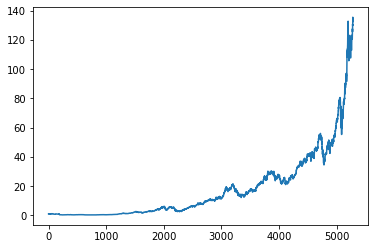

In [4]:
#read in the dataset
#dataset is 20 years of Apple stock history from Jan 2000 - Dec 2020
data = pd.read_csv("D:\Downloads\AAPL.csv")
data.head()
print(data)
#need to check for null values
print(data.count())
data['Adj Close'].plot()
adj_close = pd.DataFrame(data['Adj Close'])
targets = adj_close

In [5]:
#scale the data to be easier to process
features = ['Open', 'High', 'Low', 'Volume']
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)
scaled_data.head()

,Open,High,Low,Volume
0,0.005111,0.005550,0.005076,0.067250
1,0.005330,0.005429,0.005043,0.064077
2,0.005038,0.005425,0.005164,0.100102
3,0.005192,0.005195,0.004631,0.098700
4,0.004569,0.004809,0.004664,0.057082


In [6]:
#create testing, validation, and training datasets
#utilize Time Series Split to create inputs and output sets
num_splits = 10
gap = 0
time_series_split = TimeSeriesSplit(n_splits=num_splits, gap=gap)
print(len(features))
data_splitter = time_series_split.split(scaled_data)
for train, test in data_splitter:
    train_data, test_data = scaled_data[:len(train)], scaled_data[len(train):len(train) + len(test)]
    train_targets, test_targets = targets[:len(train)], targets[len(train):len(train) + len(test)]
print(train_data)
print(train_targets)
print(test_data)
print(test_targets)

4
          Open      High       Low    Volume
0     0.005111  0.005550  0.005076  0.067250
1     0.005330  0.005429  0.005043  0.064077
2     0.005038  0.005425  0.005164  0.100102
3     0.005192  0.005195  0.004631  0.098700
4     0.004569  0.004809  0.004664  0.057082
...        ...       ...       ...       ...
4798  0.294450  0.298092  0.296991  0.027783
4799  0.299638  0.303234  0.305063  0.016745
4800  0.301180  0.303198  0.307617  0.012372
4801  0.301996  0.308034  0.310133  0.011736
4802  0.311883  0.314205  0.319584  0.014232

[4803 rows x 4 columns]
      Adj Close
0      0.854541
1      0.782494
2      0.793945
3      0.725238
4      0.759592
...         ...
4798  39.995453
4799  40.283459
4800  40.302830
4801  41.447628
4802  42.156765

[4803 rows x 1 columns]
          Open      High       Low    Volume
4803  0.315130  0.315089  0.320516  0.009972
4804  0.311048  0.312148  0.315837  0.011870
4805  0.304862  0.306230  0.312258  0.007578
4806  0.308599  0.307222  0.313806  

In [7]:
#process the data for consumption
train_x = np.array(train_data)
train_y = np.array(train_targets)
test_x = np.array(test_data)
test_y = np.array(test_targets)
#need a 3d shape
print(train_x.shape)
train_input = train_x.reshape(train_x.shape[0], 1, train_x.shape[1])
print(train_input.shape)
test_input = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])
print(test_input.shape)


(4803, 4)
(4803, 1, 4)
(480, 1, 4)


In [8]:
#create the LSTM model
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1,train_data.shape[1]), activation = 'relu', return_sequences=False))
#regression requires only one output
lstm.add(tf.keras.layers.Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [9]:
#training the model and get the training data
history = lstm.fit(train_input, train_y, epochs=50, batch_size=8, verbose=1, shuffle=False, validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4322 samples, validate on 481 samples
Epoch 1/50
4322/4322 [==============================] - 9s 2ms/sample - loss: 11.3277 - val_loss: 34.6774
Epoch 2/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 30.3059 - val_loss: 7.0569
Epoch 3/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 17.6946 - val_loss: 0.5327
Epoch 4/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 8.5318 - val_loss: 3.8024
Epoch 5/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 3.5481 - val_loss: 8.4551
Epoch 6/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 1.5076 - val_loss: 12.4054
Epoch 7/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 0.7894 - val_loss: 14.4113
Epoch 8/50
4322/4322 [==============================] - 8s 2ms/sample - loss: 0.5272 - val_loss: 14.7730
Epoch 9/50
4322/4322

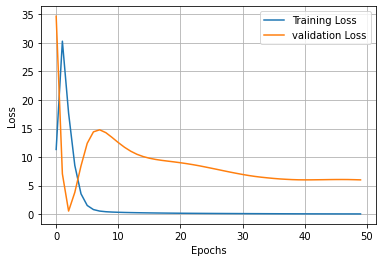

In [10]:
#visualize training data
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

In [14]:
#predict outputs 
preds = lstm.predict(test_input)

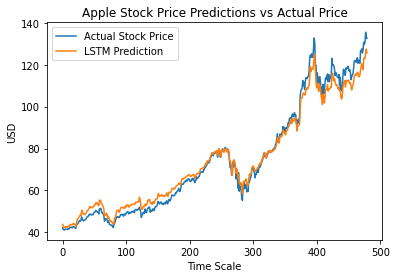

In [15]:
plt.plot(test_y, label= "Actual Stock Price")
plt.plot(preds, label= "LSTM Prediction")
plt.title("Apple Stock Price Predictions vs Actual Price")
plt.xlabel("Time Scale")
plt.ylabel("USD")
plt.legend()
plt.show()

In [16]:
#Prediction Statistics
#Root Mean Square Error (RSME): standard deviation of prediction errors
def RSME(actual, pred):
    inner_sum = np.square(actual - pred)
    summation = np.mean(inner_sum)
    return np.sqrt(summation)

#Mean Absolute Percentage Error (MAPE): measure of prediction accuracy, percentage based
def MAPE(actual, pred):
    inner_sum = np.abs((actual - pred)/actual)
    return np.mean(inner_sum)*100
    
#Mean Bias Error (MBE): Average bias in the prediction
def MBE(actual, pred):
    errors = actual - preds
    return errors.mean()

print(f'Root Mean Square Error: {RSME(test_y, preds):2f}')
print(f'Mean Absolute Percentage Error: {MAPE(test_y, preds):2f}%')
print(f'Mean Bias Error: {MBE(test_y, preds):2f}')

Root Mean Square Error: 3.554455
Mean Absolute Percentage Error: 4.159176%
Mean Bias Error: -0.133495
